# ML Model for Anomaly Detection in CCTV Surveillance :

In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

### Data Collection :

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [4]:
print(f"Total videos for training : {len(train_df)}")
print(f"Total videos for testing  : {len(test_df)}")

print("Training Dataframe : ")
print(train_df.sample(10))

print("Testing Dataset    : ")
print(test_df.sample(10))

Total videos for training : 1520
Total videos for testing  : 380
Training Dataframe : 
      Unnamed: 0     label                             video_name
348         1027    normal  data\normal\Normal_Videos689_x264.mp4
238           25     abuse           data\abuse\Abuse026_x264.mp4
683          205  burglary     data\burglary\Burglary006_x264.mp4
939          385  fighting     data\fighting\Fighting037_x264.mp4
12          1833  stealing     data\stealing\Stealing097_x264.mp4
708         1516   robbery       data\robbery\Robbery017_x264.mp4
162         1513   robbery       data\robbery\Robbery014_x264.mp4
1329         233  burglary     data\burglary\Burglary034_x264.mp4
736           29     abuse           data\abuse\Abuse030_x264.mp4
909          223  burglary     data\burglary\Burglary024_x264.mp4
Testing Dataset    : 
     Unnamed: 0        label                                video_name
67         1646      robbery          data\robbery\Robbery147_x264.mp4
244        1806     ste

### Feed the videos to a Network : 

In [5]:
IMG_SIZE = 299

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y,x)
    # print(f"y : {y}      and      x : {x}")
    start_x = (x // 2) -  (min_dim // 2) 
    start_y = (y // 2) -  (min_dim // 2)
    return frame[ start_y : start_y+min_dim, start_x : start_x + min_dim]

In [6]:
def load_video(path, max_frames = 0, resize = (IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    # allPaths = path.split('/')
    # videoNameAndExt = allPaths[2].split('.')
    # videoName = videoNameAndExt[0] 
    frames = []
    # i = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # if (not os.path.exists('frames/'+videoName)):
            #     os.mkdir('frames/'+videoName)
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2,1,0]]
            # cv2.imwrite('frames/'+ videoName +'/Frame'+ str(i) +'.jpg', frame)
            frames.append(frame)
            # i+=1
            if(len(frames) == max_frames):
                break
    finally:
        cap.release()
    return np.array(frames)

### Transfer Learning & Feature Extraction :

In [7]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [8]:
print(feature_extractor.summary())

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________
None


In [9]:
from keras.utils.vis_utils import plot_model

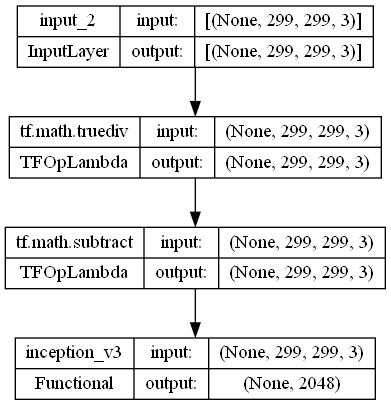

In [10]:
plot_model(feature_extractor, to_file='plots/model_plot.png', show_shapes=True, show_layer_names=True)

### Label Encoding
StringLookup layer encode the class labels as integers.

In [11]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["label"]))
print(label_processor.get_vocabulary())

labels = train_df["label"].values
labels = label_processor(labels[..., None]).numpy()
labels

['abuse', 'arrest', 'arson', 'assault', 'burglary', 'explosion', 'fighting', 'normal', 'roadaccidents', 'robbery', 'shooting', 'shoplifting', 'stealing', 'vandalism']


array([[7],
       [7],
       [7],
       ...,
       [7],
       [7],
       [7]], dtype=int64)

<b>Finally, we can put all the pieces together to create our data processing utility.</b>

In [12]:
#Define hyperparameters

IMG_SIZE = 299
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()    
    
    ##take all classlabels from train_df column named 'label' and store in labels
    labels = df["label"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") 
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") 

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(path))
        frames = frames[None, ...]
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels